In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BILL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,5124,-3586,1538,329,737,2601,3145,7408,0,...,2502,0,2417,6539,4672,15094,899,-480,207.32,2015-01-25
1,2015-03-31,5634,-3868,1766,504,545,2781,3140,7190,0,...,2524,0,2324,6495,3844,14255,977,-246,206.95,2015-04-25
2,2015-06-30,5489,-3794,1695,403,214,2630,3024,7184,0,...,2551,0,2445,6472,3746,14160,821,-496,206.95,2015-07-20
3,2015-09-30,5478,-3850,1628,862,377,2695,2888,6696,0,...,2610,0,1384,5450,3537,13065,956,-416,206.95,2015-10-25
4,2015-12-31,5213,-3720,1493,199,188,2512,2842,6546,0,...,2679,0,1368,5624,3027,12830,904,-514,206.95,2016-01-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-10-25,248.56,10210,-7702,2508,656,1363,4577,6568,...,2251,48933,5030,0,3376,11472,4207,21183,1082,-638
36,2023-12-31,2024-01-25,248.56,9566,-7341,2225,-330,2304,3804,6137,...,2227,47926,5352,0,2704,10965,4696,20981,2216,-973
37,2024-03-31,2024-04-22,248.55,10423,-7739,2684,313,1561,4527,6516,...,2243,48842,5592,0,1860,10812,5256,21348,195,-686
38,2024-06-30,2024-07-15,248.70,10764,-8323,2441,63,1826,4542,6577,...,2240,49289,5698,0,2805,12044,5053,22148,678,-629
39,2024-09-30,2024-10-21,248.70,10798,-7838,2960,565,1483,4553,6781,...,2225,48273,4882,0,2711,11027,5001,21074,438,-509


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-10-25,248.56,10210,-7702,2508,656,1363,4577,6568,...,48933,5030,0,3376,11472,4207,21183,1082,-638,10.805716
36,2023-12-31,2024-01-25,248.56,9566,-7341,2225,-330,2304,3804,6137,...,47926,5352,0,2704,10965,4696,20981,2216,-973,10.657495
37,2024-03-31,2024-04-22,248.55,10423,-7739,2684,313,1561,4527,6516,...,48842,5592,0,1860,10812,5256,21348,195,-686,10.376655
38,2024-06-30,2024-07-15,248.70,10764,-8323,2441,63,1826,4542,6577,...,49289,5698,0,2805,12044,5053,22148,678,-629,10.684878
39,2024-09-30,2024-10-21,248.70,10798,-7838,2960,565,1483,4553,6781,...,48273,4882,0,2711,11027,5001,21074,438,-509,10.423824


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-10-25,248.56,10210,-7702,2508,656,1363,4577,6568,...,48933,5030,0,3376,11472,4207,21183,1082,-638,10.805716
36,2023-12-31,2024-01-25,248.56,9566,-7341,2225,-330,2304,3804,6137,...,47926,5352,0,2704,10965,4696,20981,2216,-973,10.657495
37,2024-03-31,2024-04-22,248.55,10423,-7739,2684,313,1561,4527,6516,...,48842,5592,0,1860,10812,5256,21348,195,-686,10.376655
38,2024-06-30,2024-07-15,248.70,10764,-8323,2441,63,1826,4542,6577,...,49289,5698,0,2805,12044,5053,22148,678,-629,10.684878
39,2024-09-30,2024-10-21,248.70,10798,-7838,2960,565,1483,4553,6781,...,48273,4882,0,2711,11027,5001,21074,438,-509,10.423824


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-01-26,88.167519,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.41289,0.58711,0.0,0.0,0.0,0.0,0.300156,0.064208,0.0,0.0
1,2015-02-02,89.427040,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.41289,0.58711,0.0,0.0,0.0,0.0,0.300156,0.064208,0.0,0.0
2,2015-02-09,92.365967,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.41289,0.58711,0.0,0.0,0.0,0.0,0.300156,0.064208,0.0,0.0
3,2015-02-16,93.555519,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.41289,0.58711,0.0,0.0,0.0,0.0,0.300156,0.064208,0.0,0.0
4,2015-02-23,92.645851,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.41289,0.58711,0.0,0.0,0.0,0.0,0.300156,0.064208,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-01-26,88.167519,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.0,0.300156,0.064208,0.0,0.0,inf,1.721987,inf,inf,inf
1,2015-02-02,89.427040,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.0,0.300156,0.064208,0.0,0.0,inf,1.746586,inf,inf,inf
2,2015-02-09,92.365967,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.0,0.300156,0.064208,0.0,0.0,inf,1.803986,inf,inf,inf
3,2015-02-16,93.555519,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.0,0.300156,0.064208,0.0,0.0,inf,1.827219,inf,inf,inf
4,2015-02-23,92.645851,2014-12-31,5124.0,0.0,51.201042,207.32,0.0,0.0,737.0,...,0.0,0.300156,0.064208,0.0,0.0,inf,1.809452,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

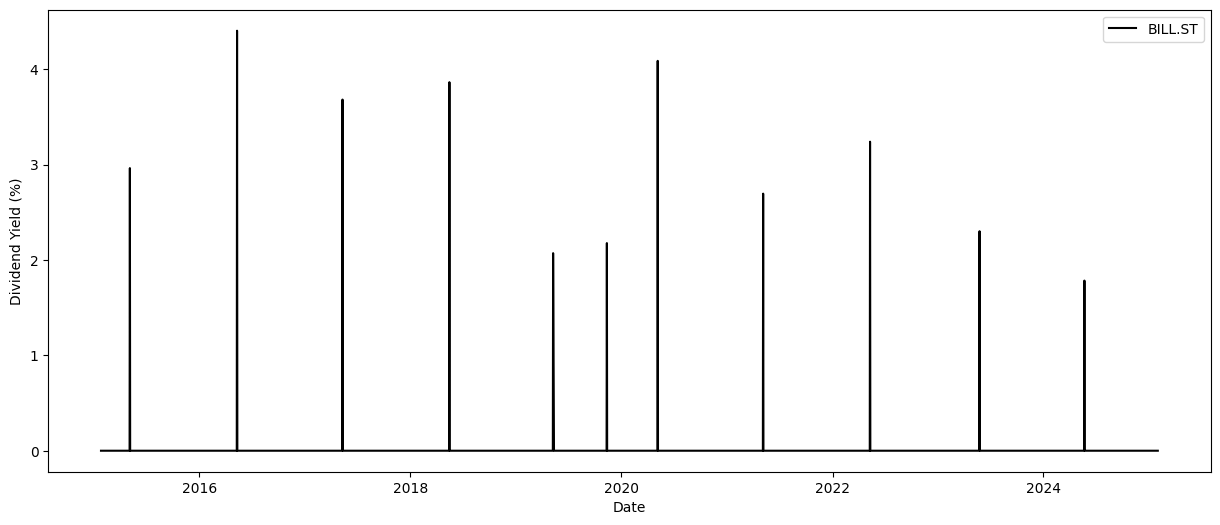

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.110315
share_price      1.000000
Name: share_price, dtype: float64


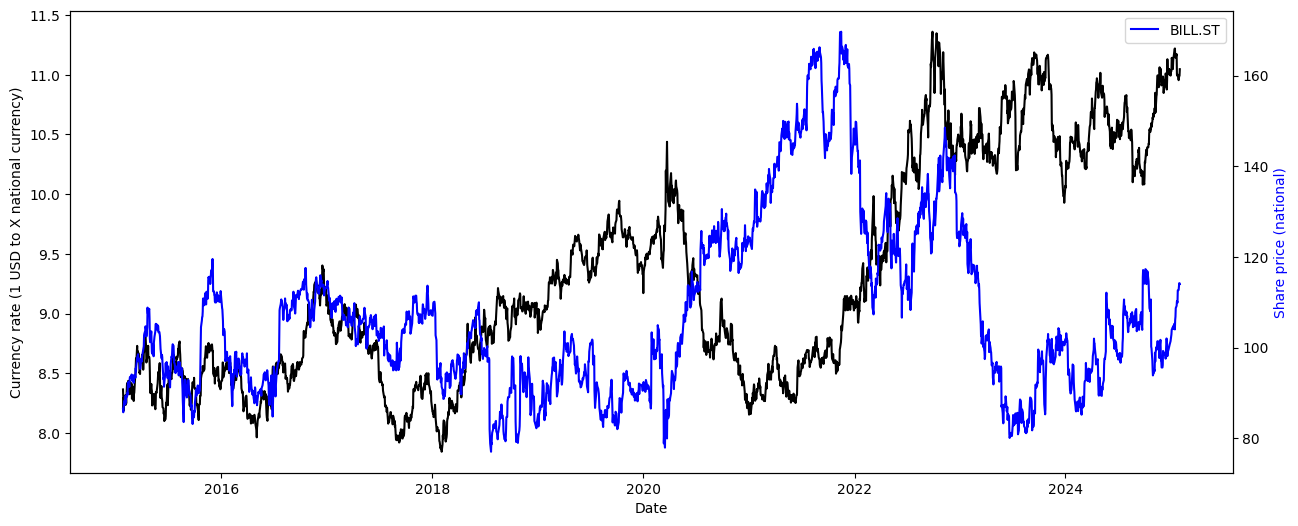

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

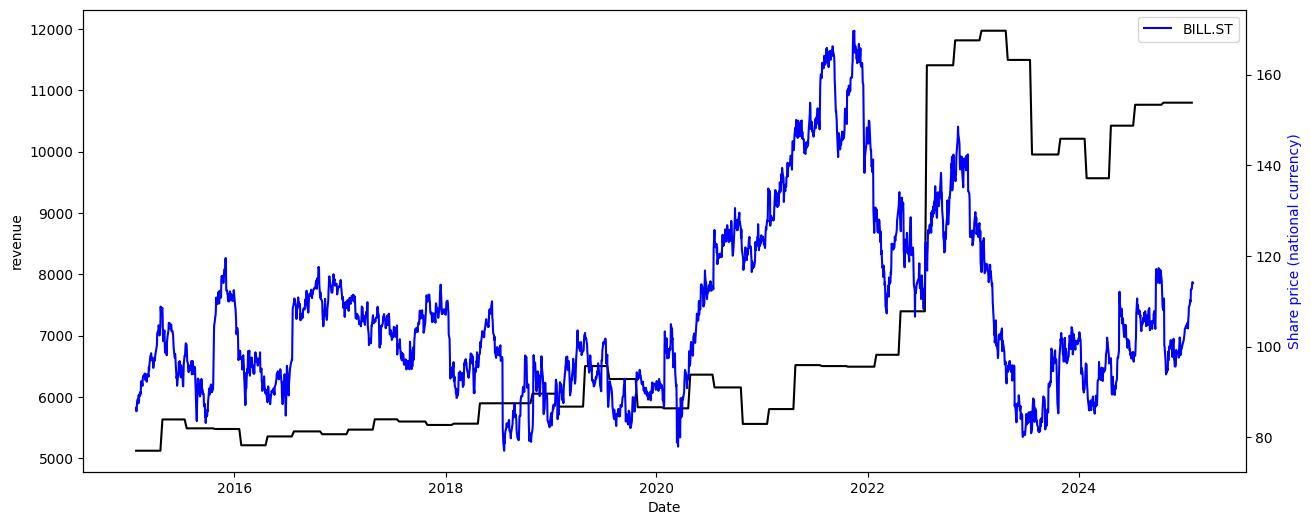

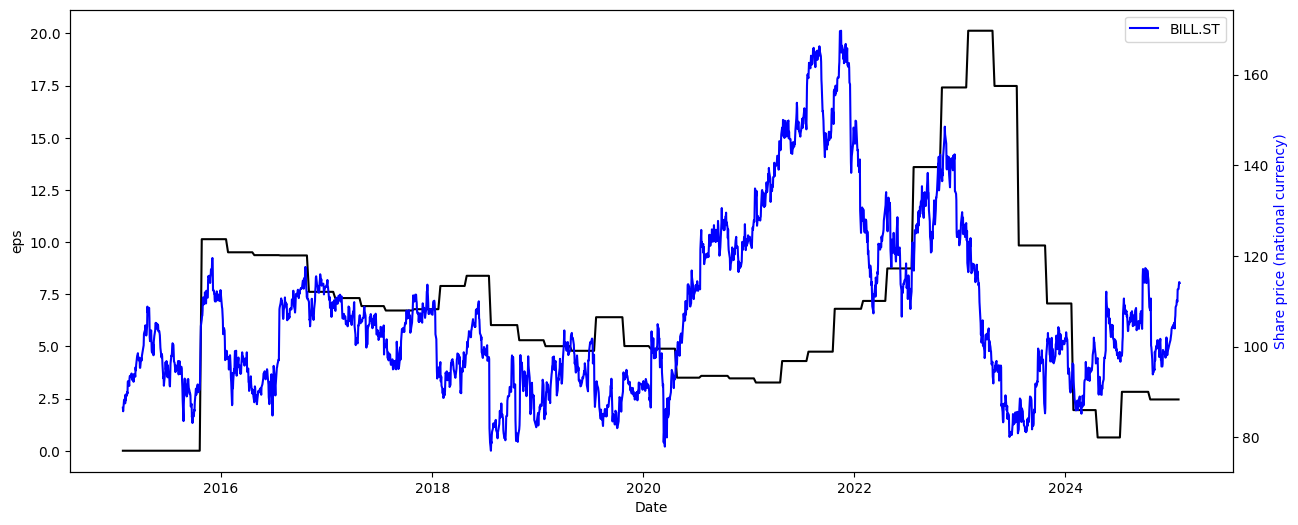

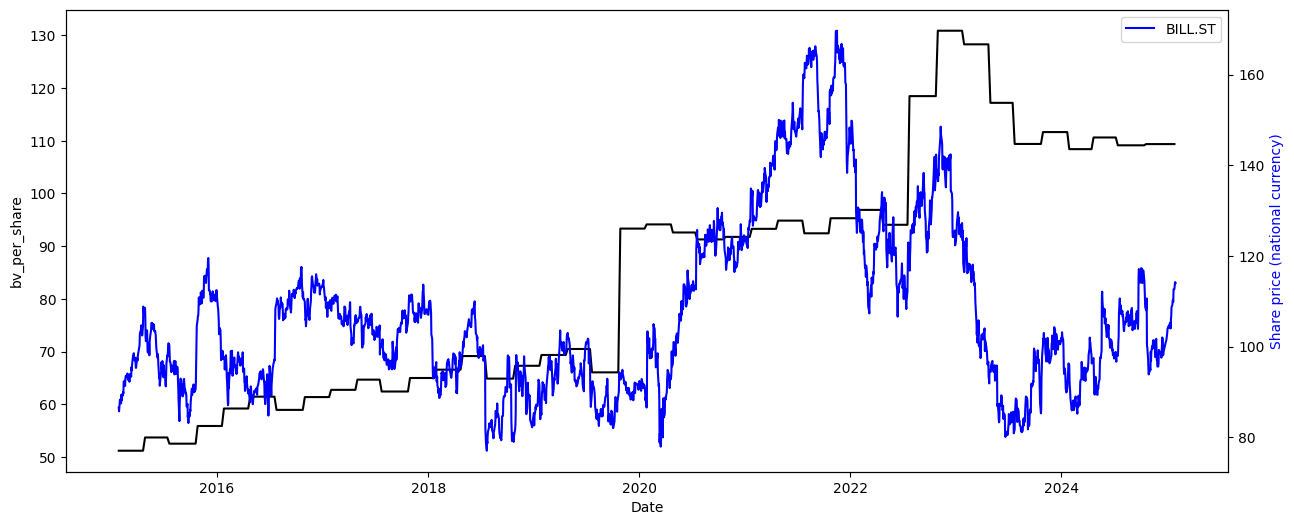

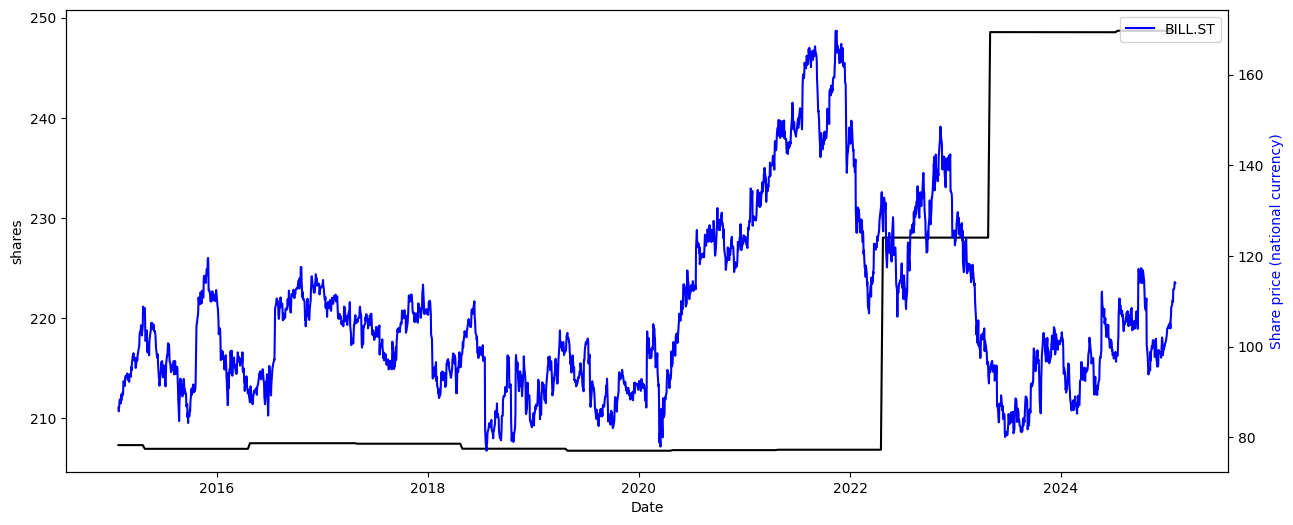

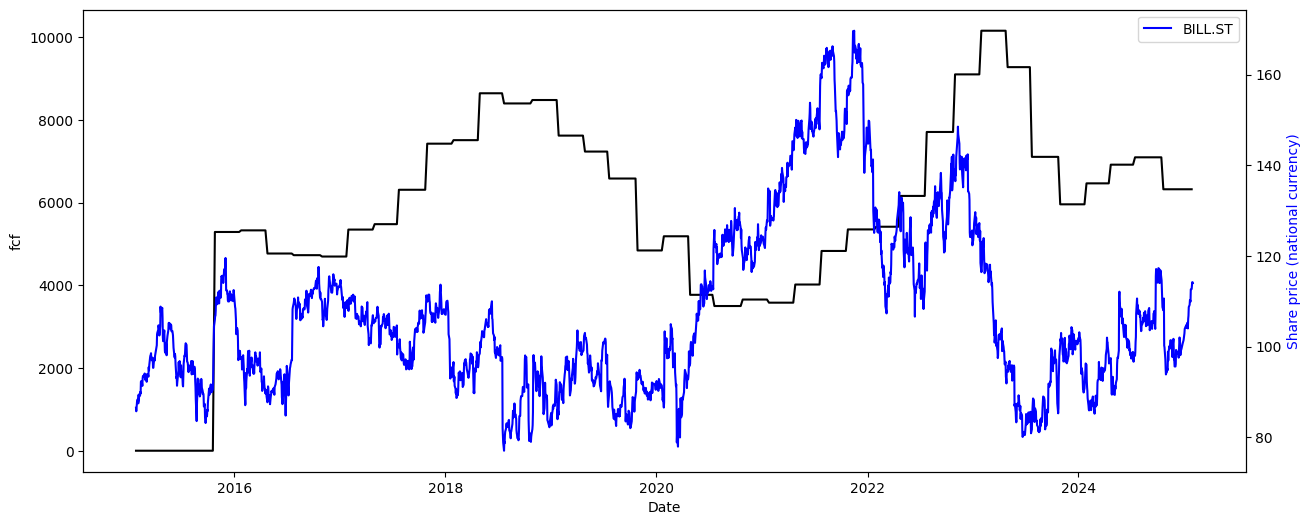

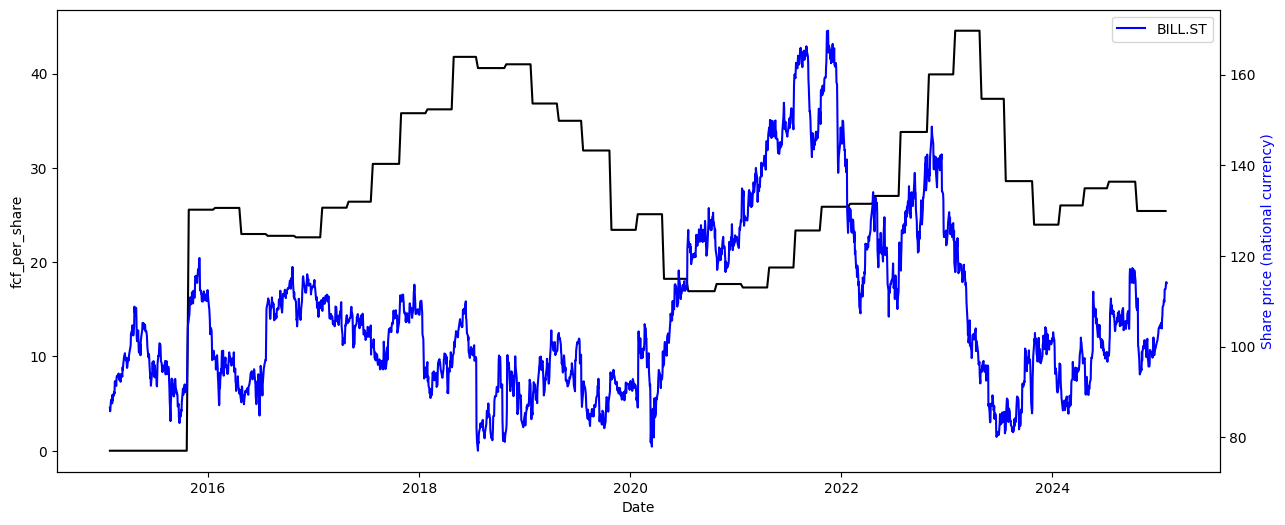

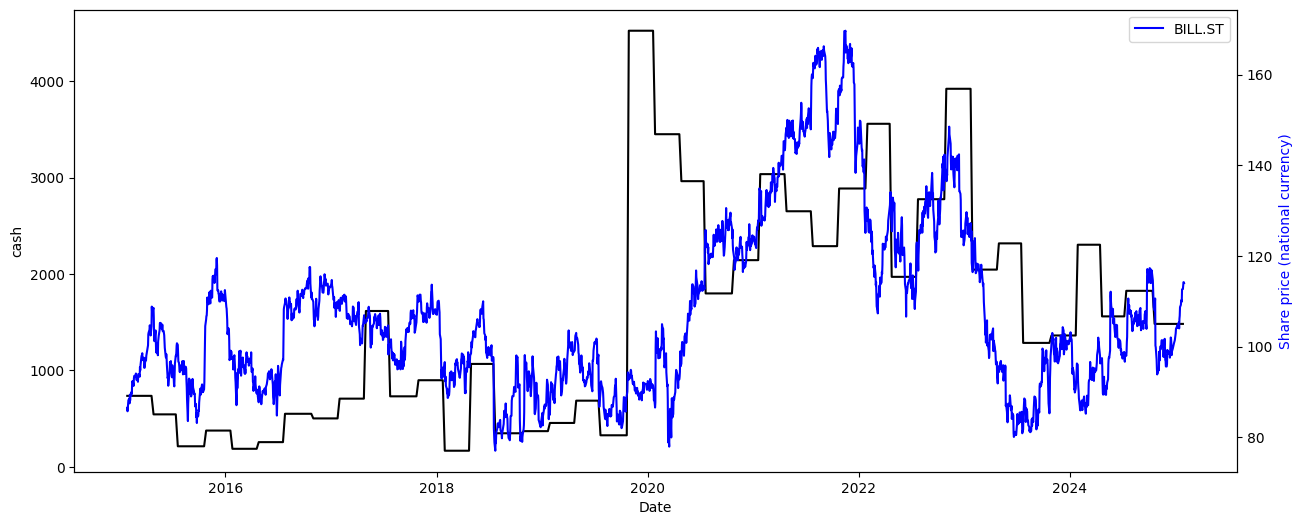

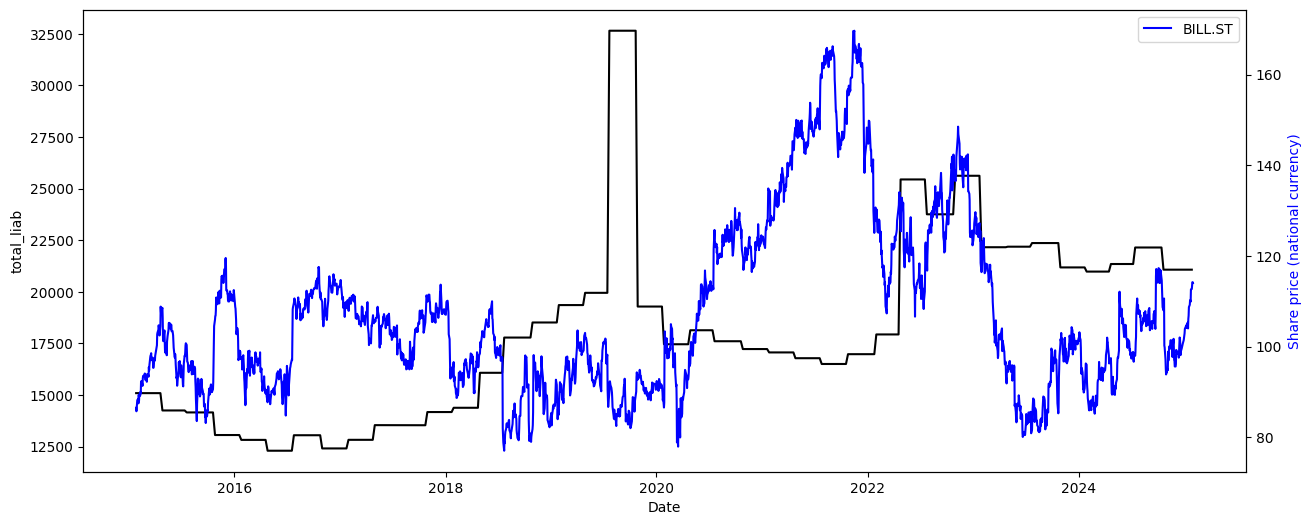

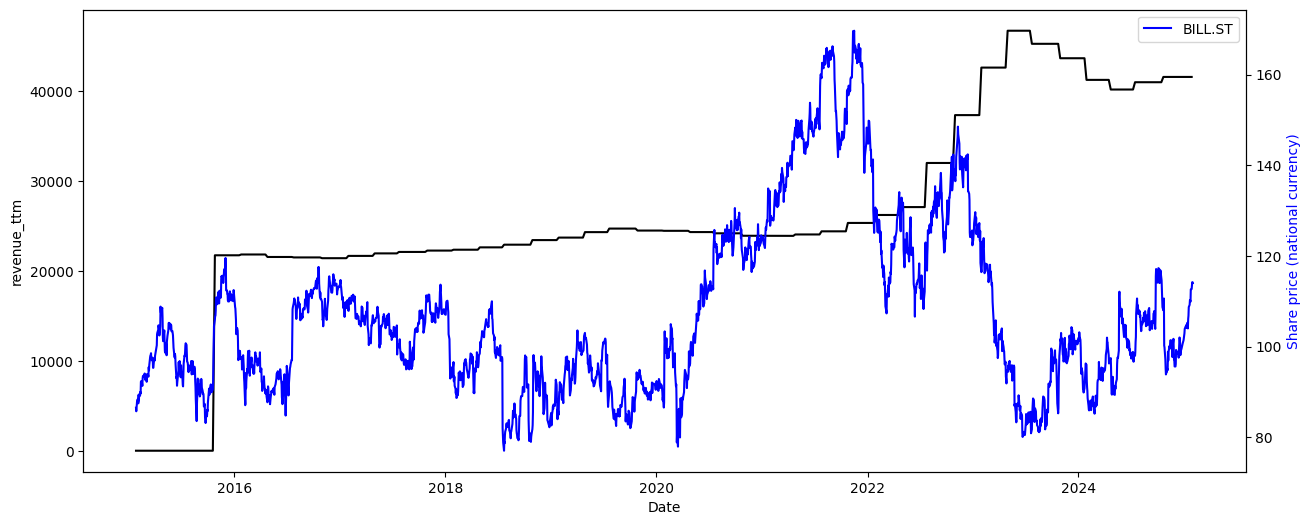

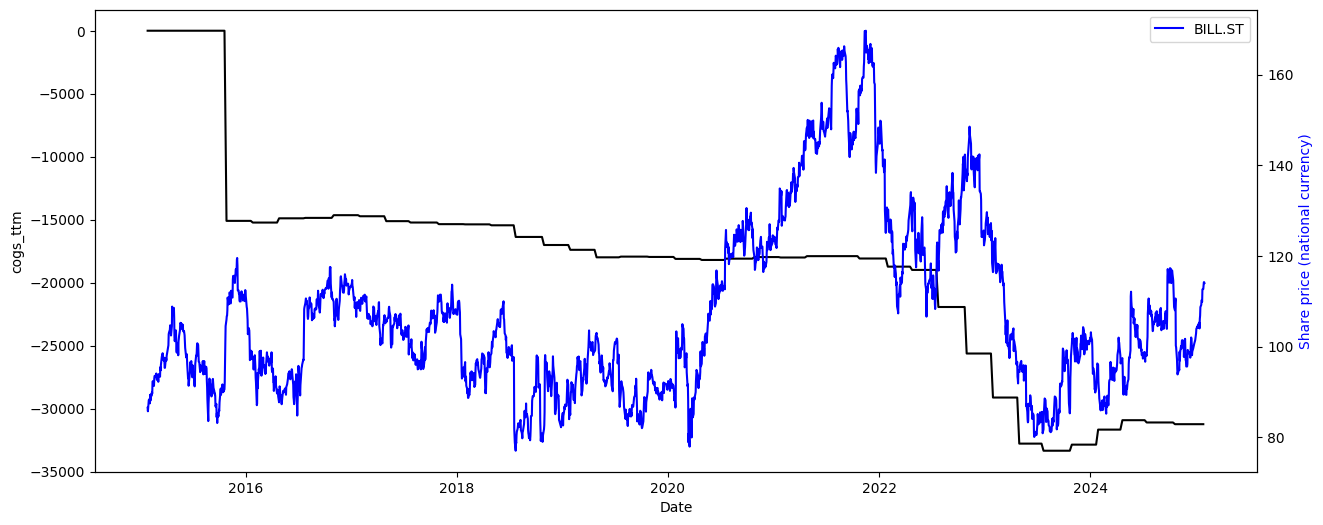

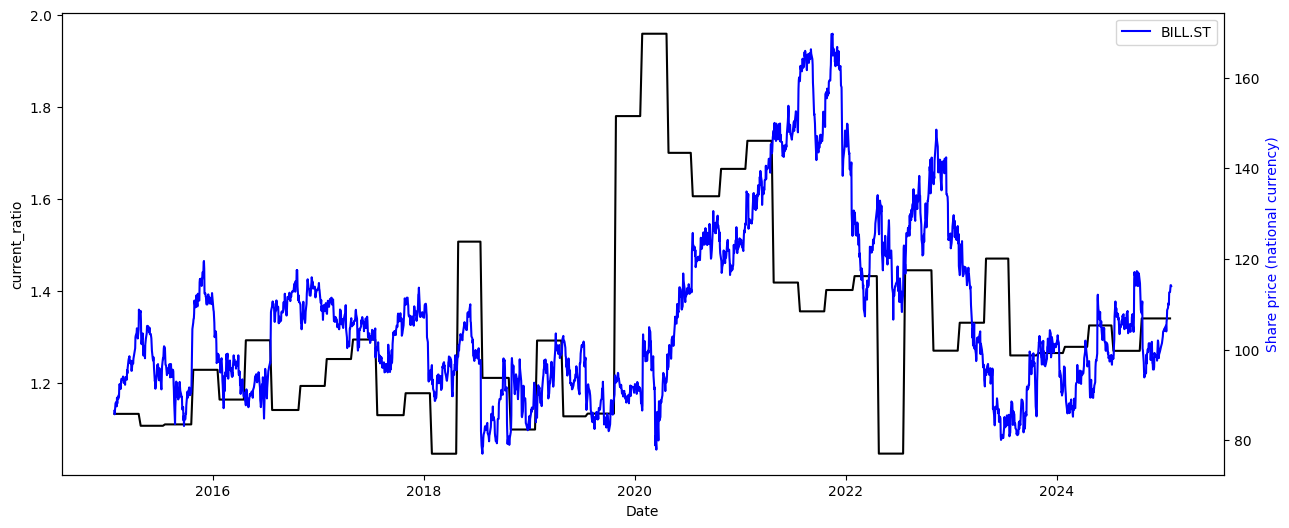

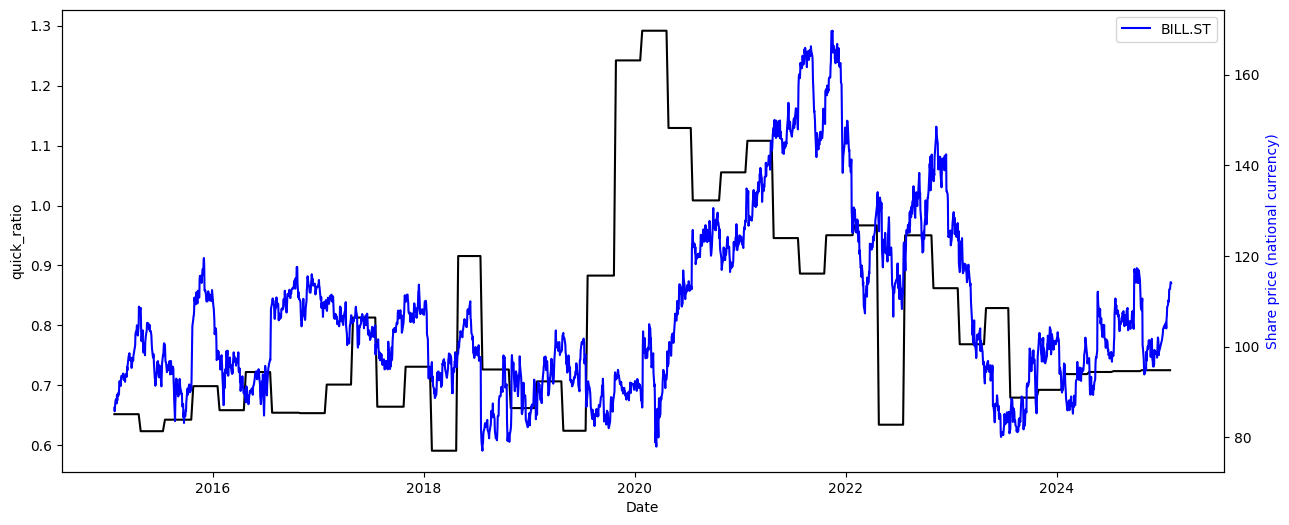

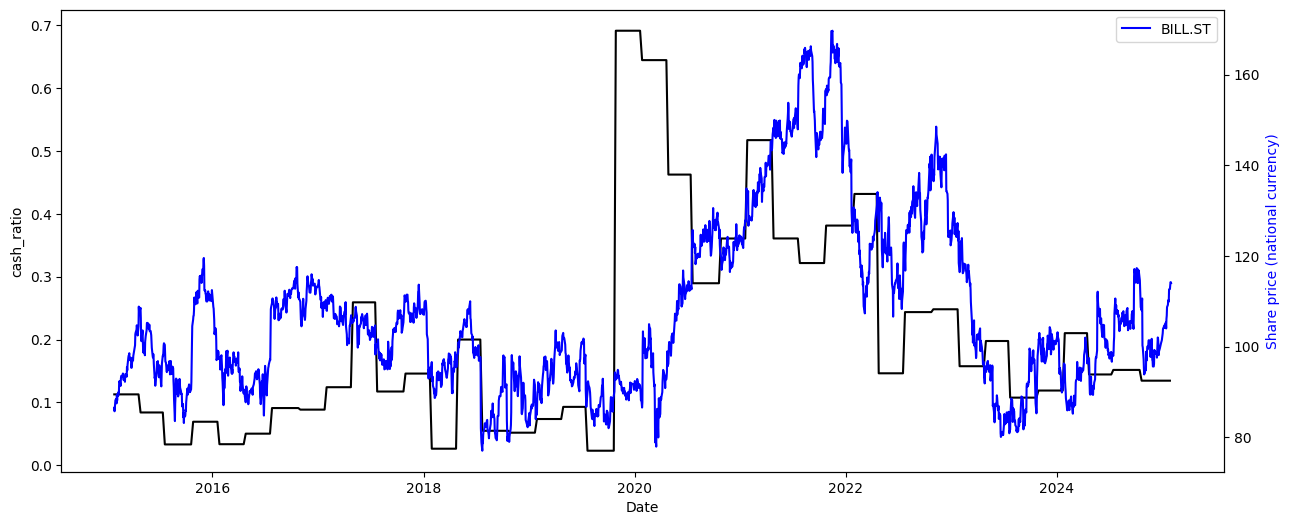

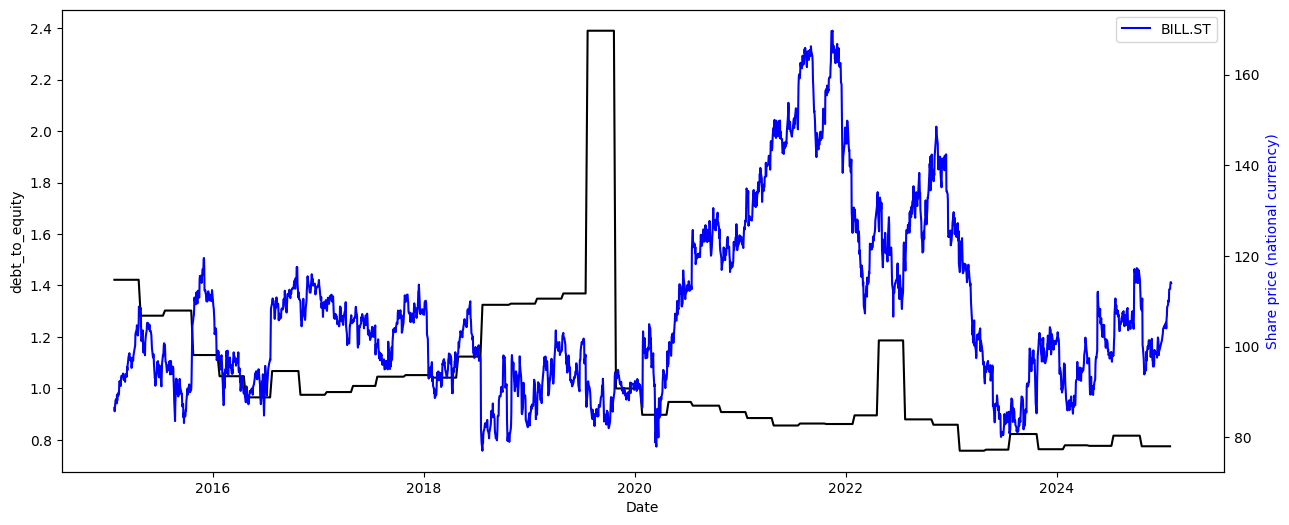

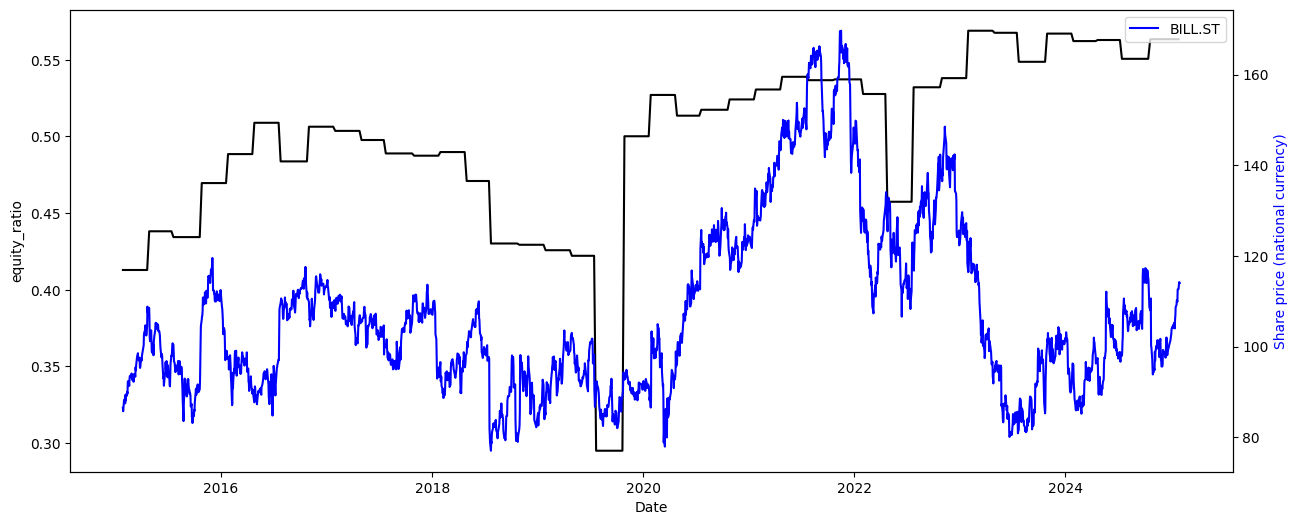

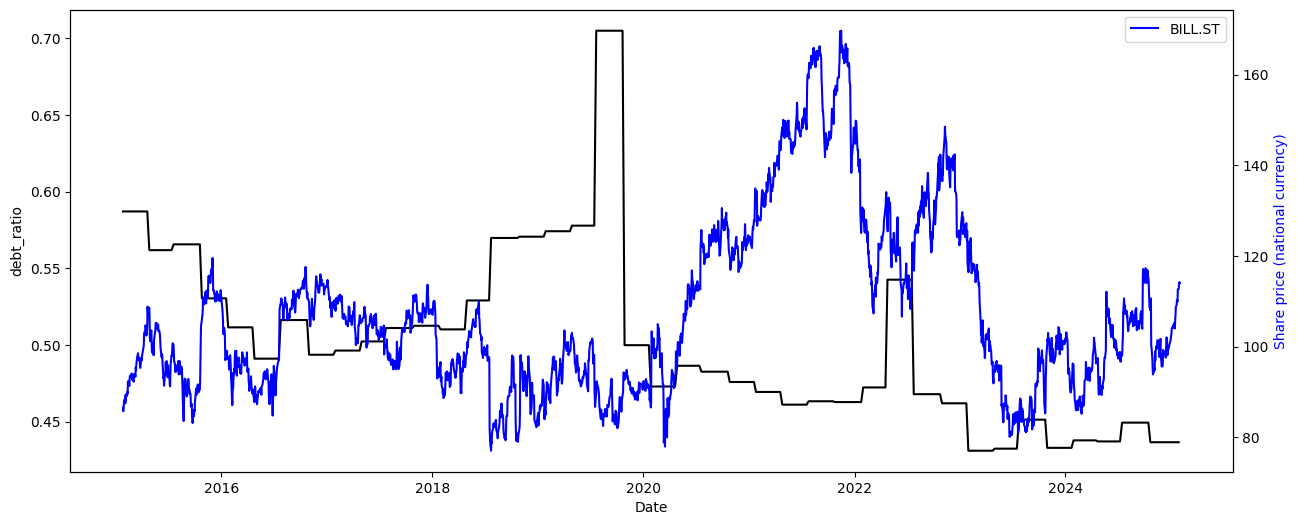

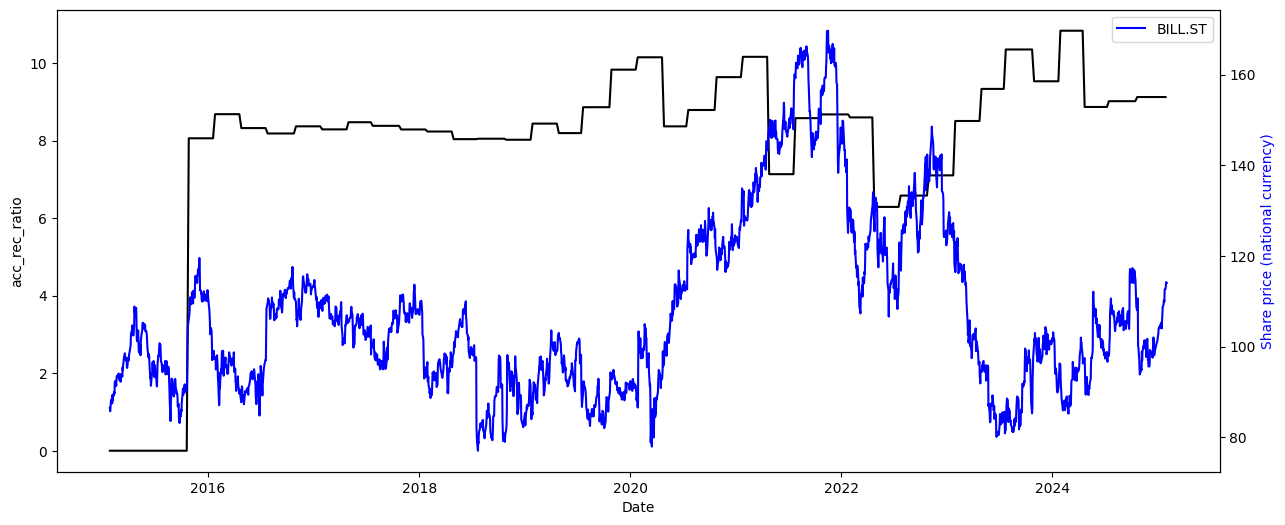

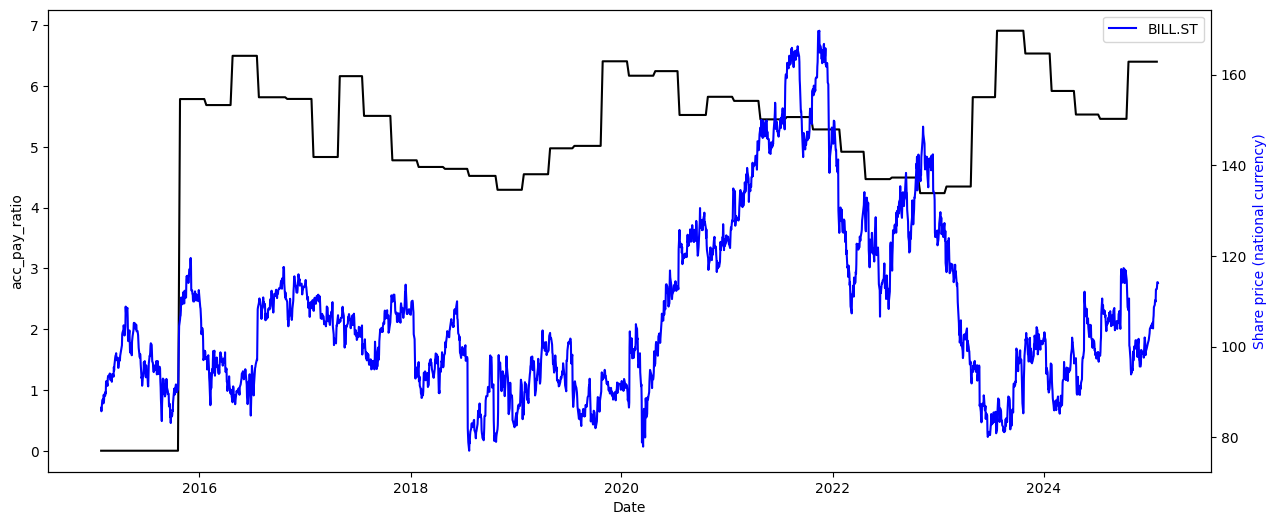

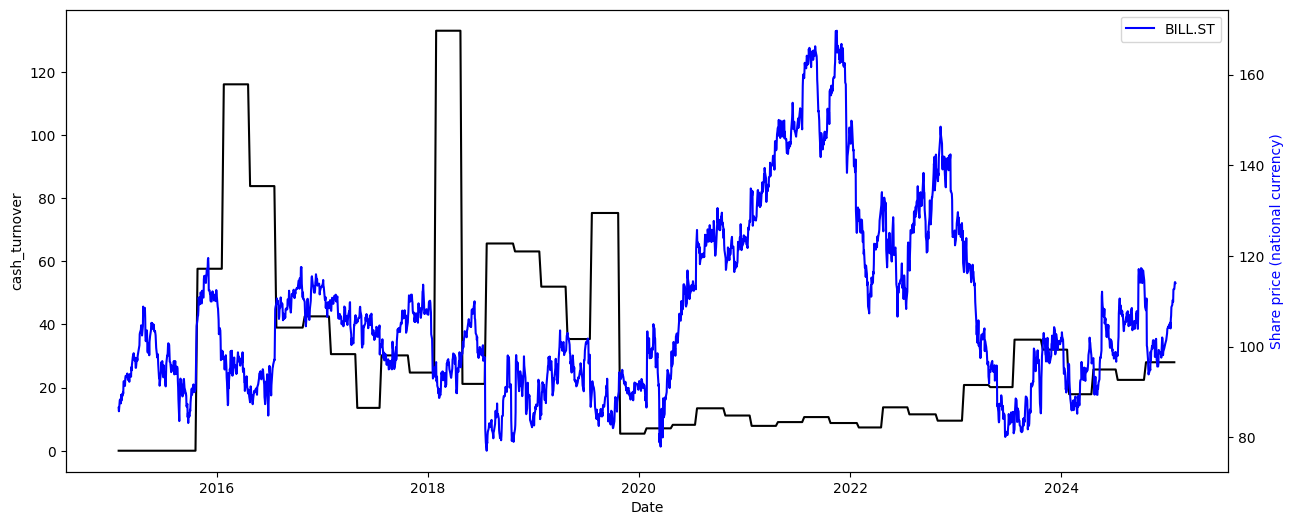

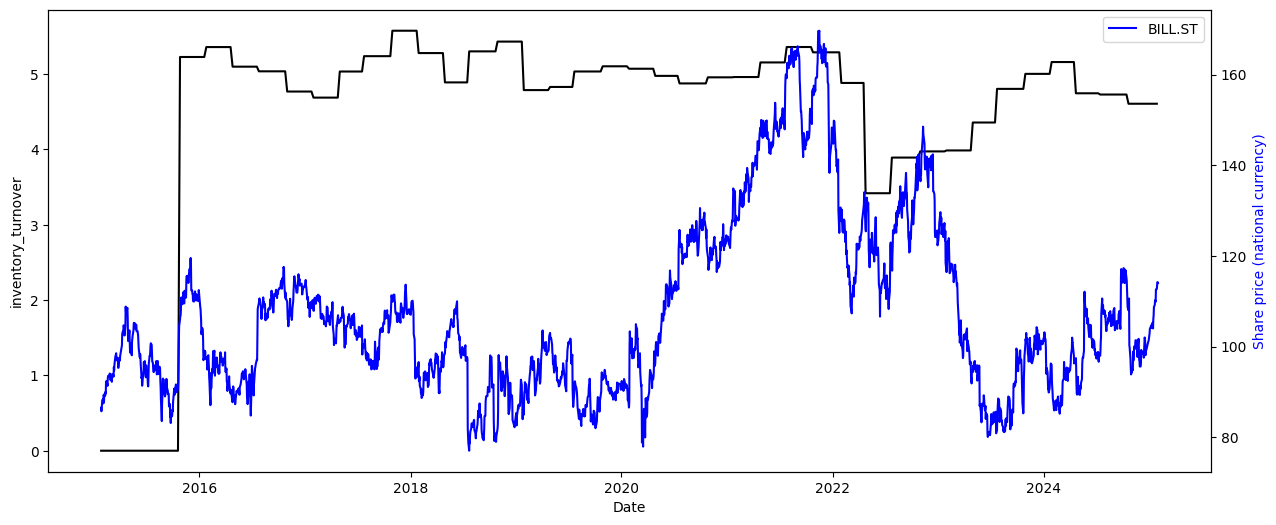

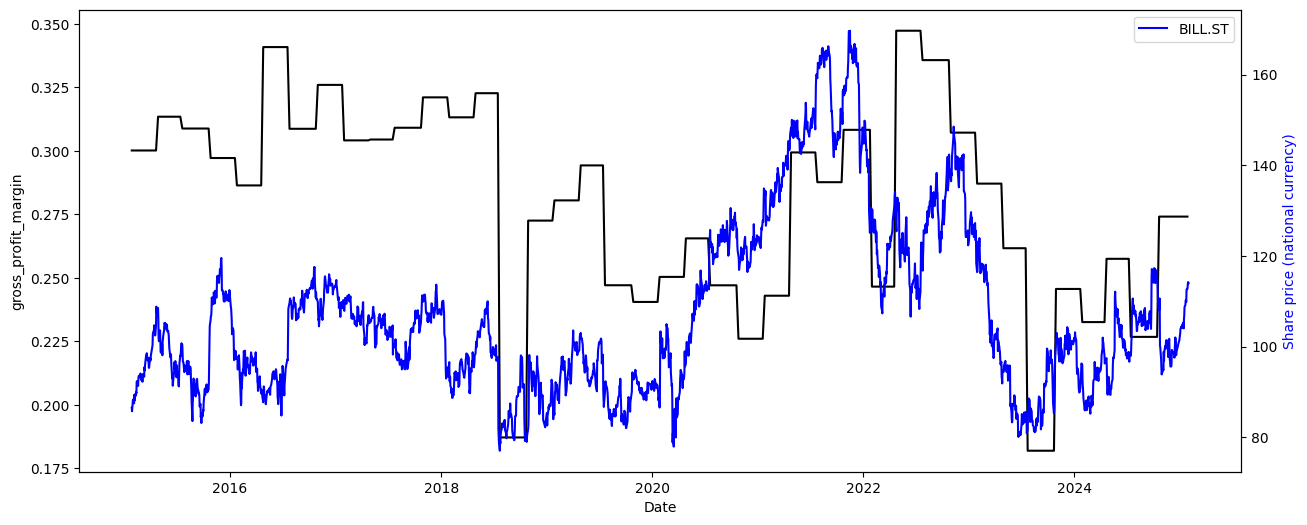

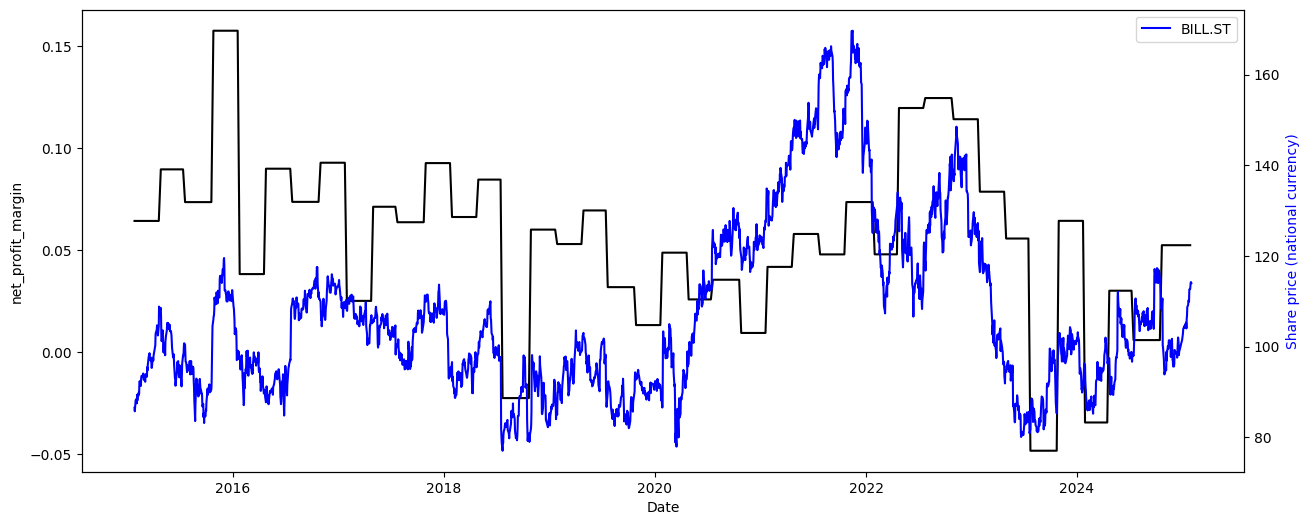

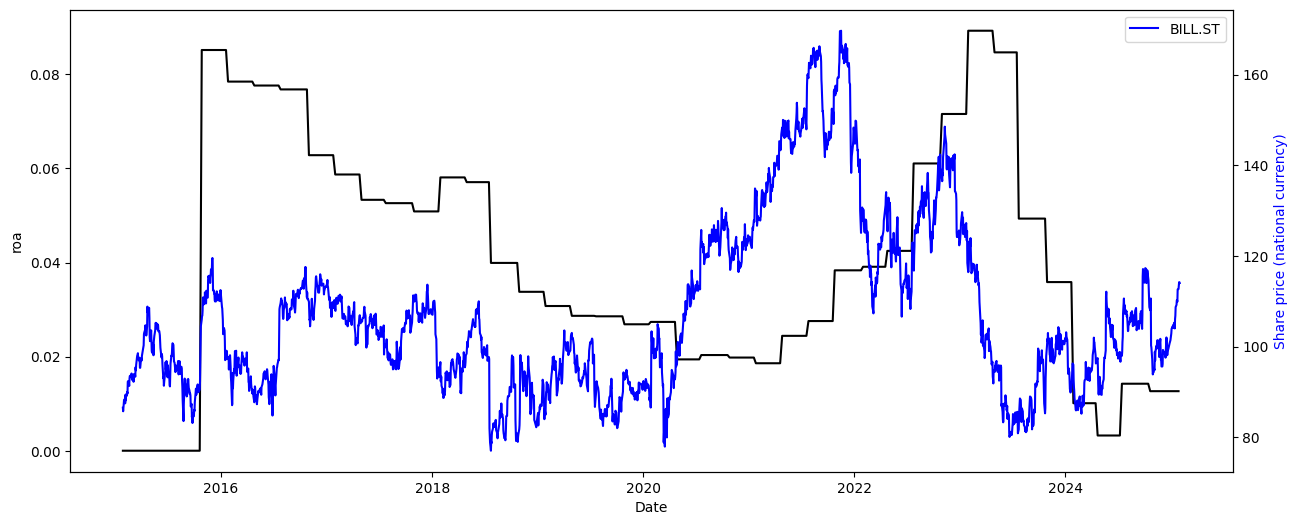

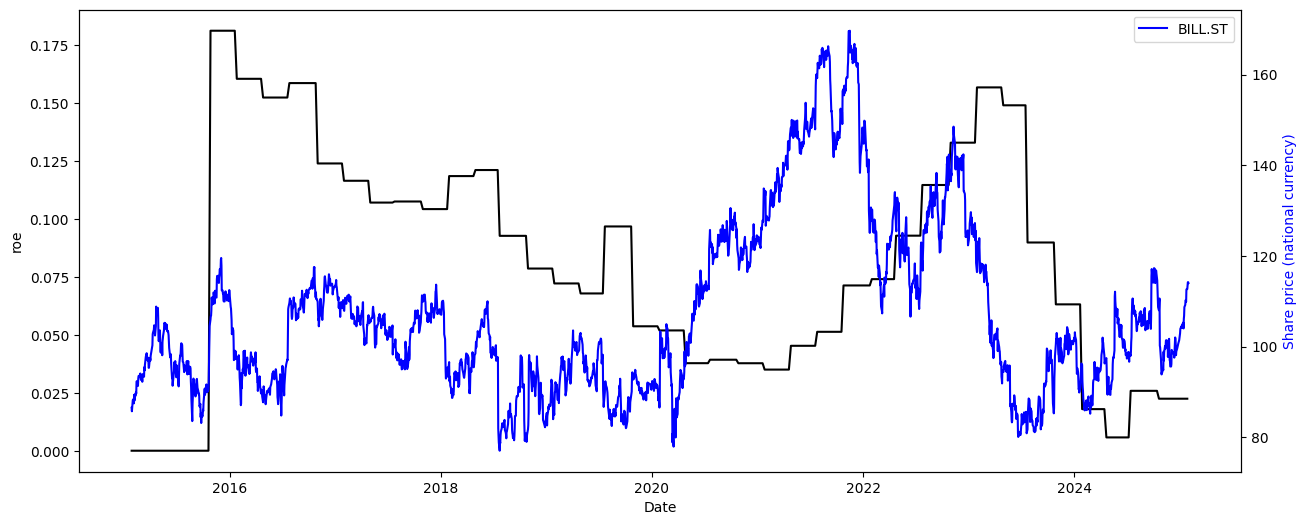

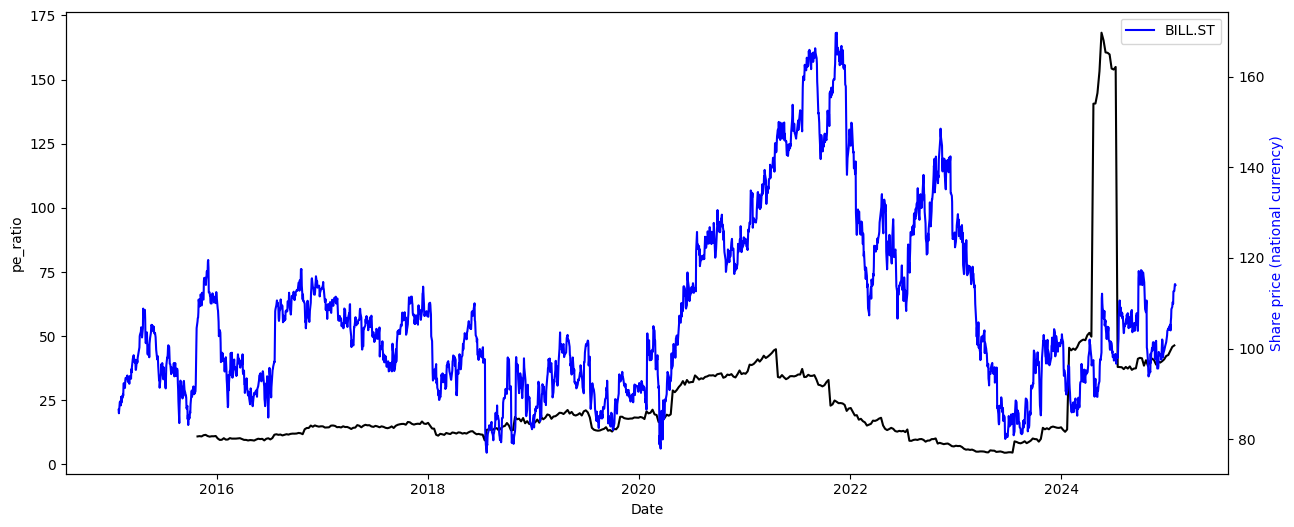

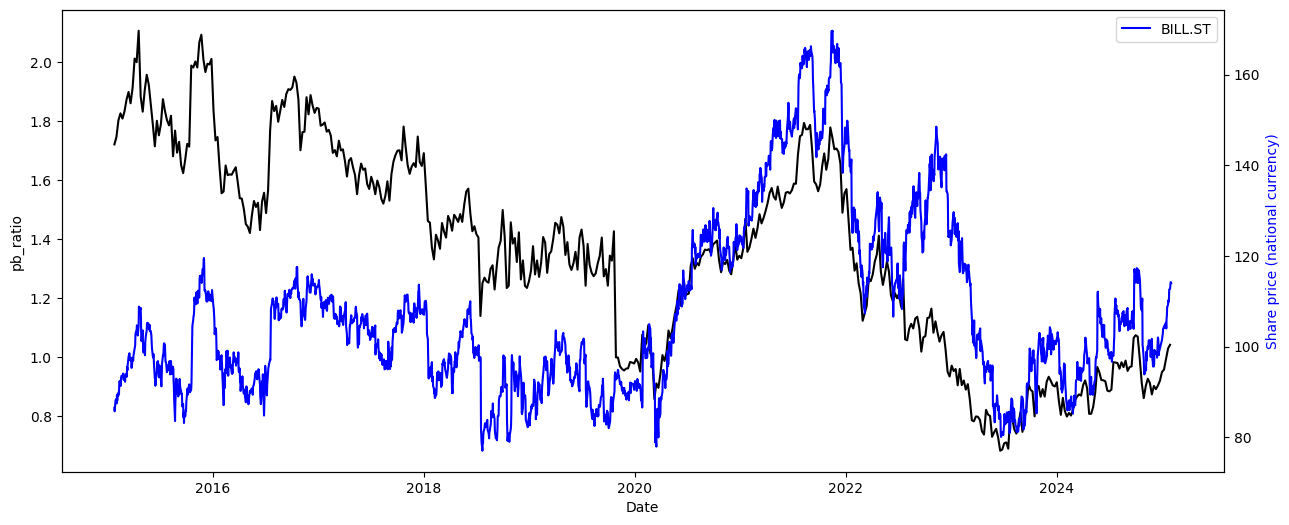

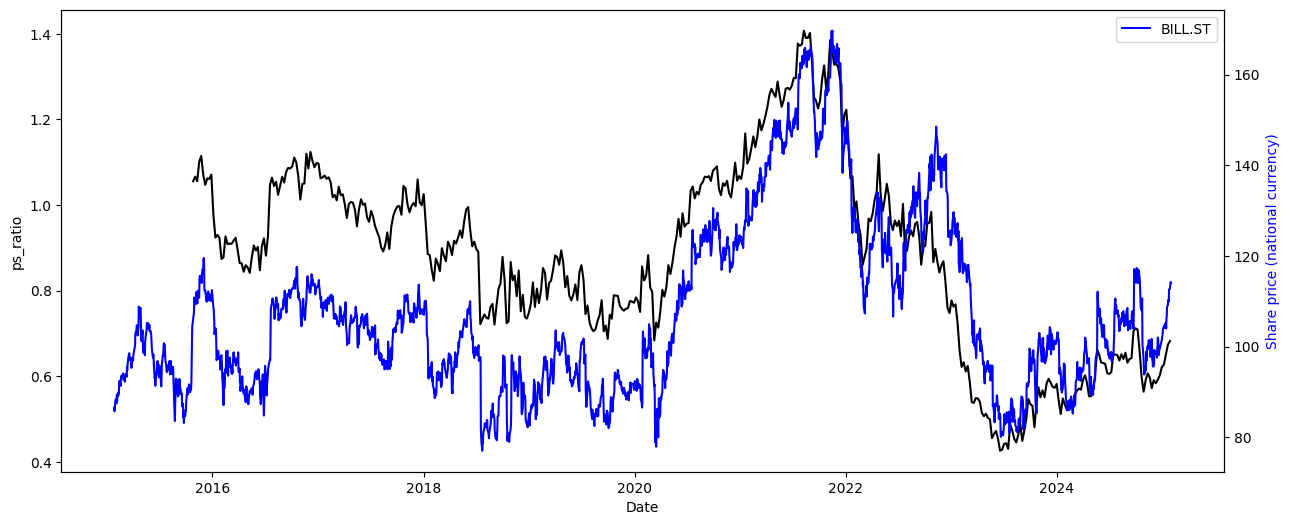

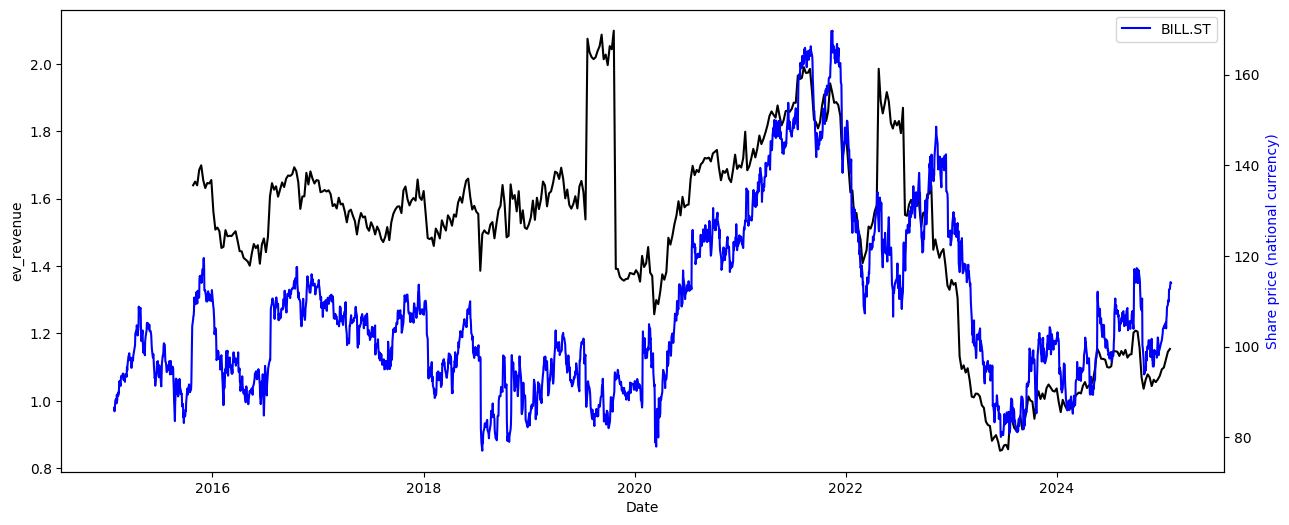

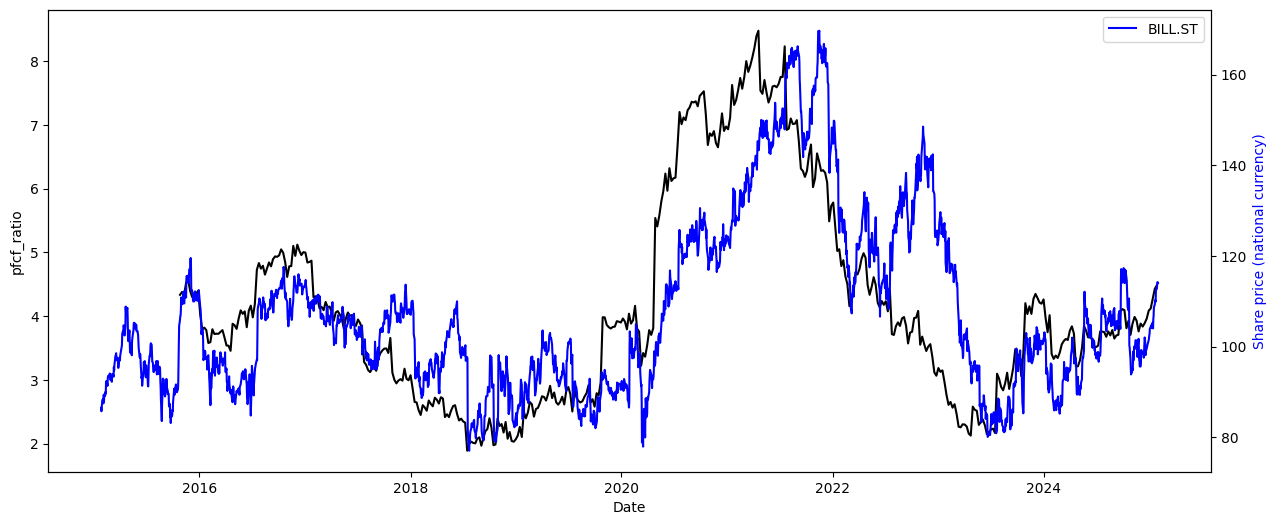

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

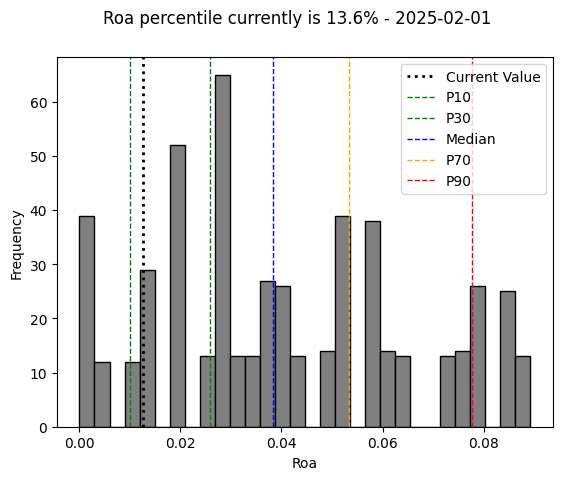

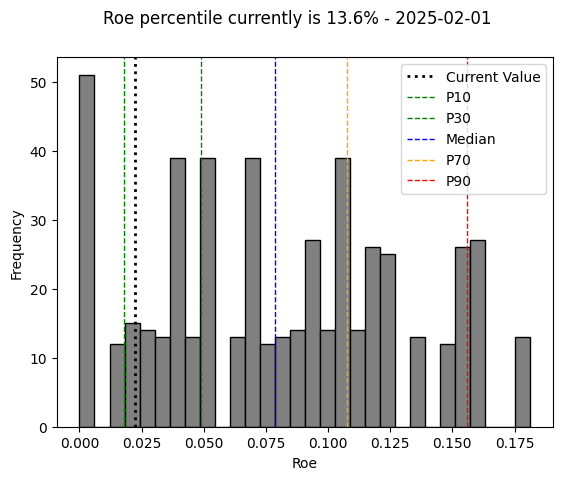

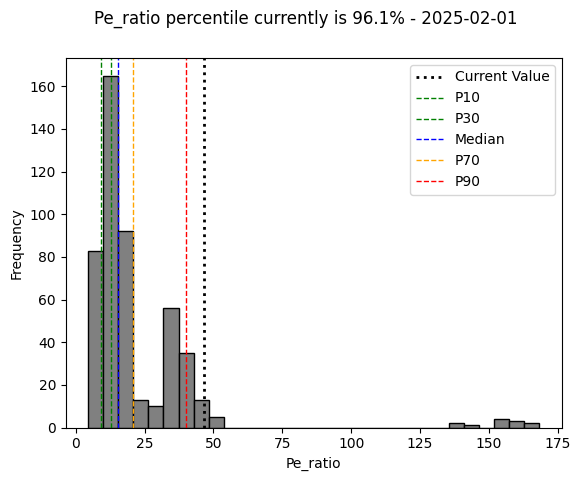

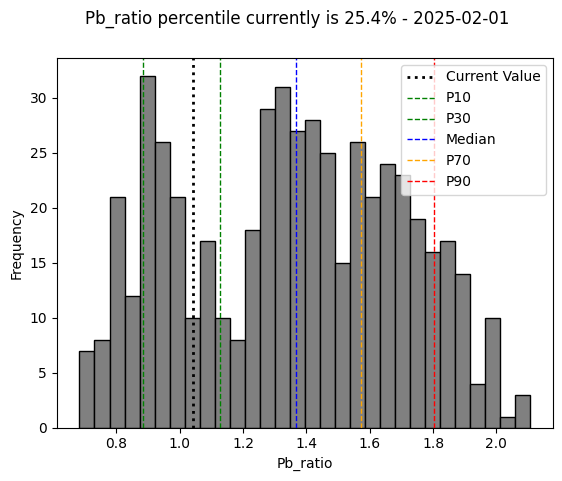

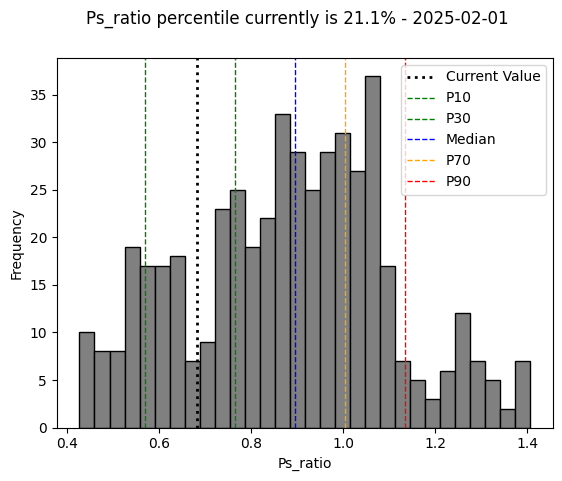

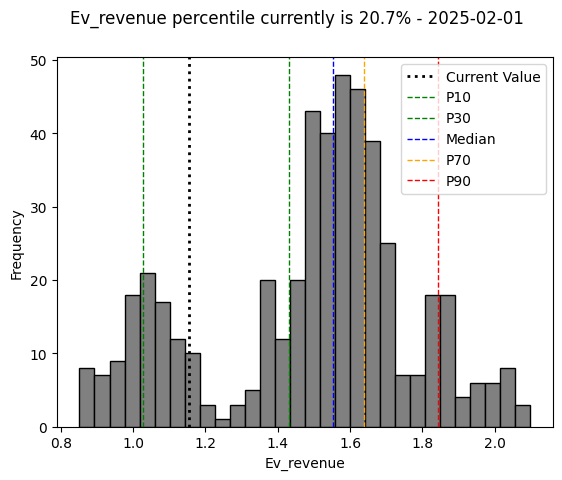

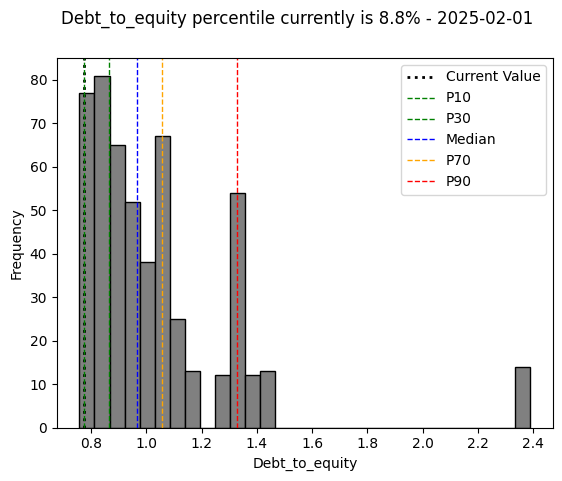

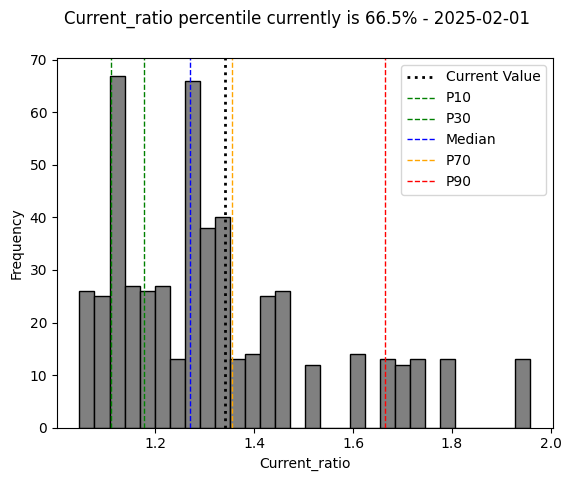

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.981183,-0.613828,0.063241,0.017150,-0.066304,-0.154599,-0.164340
roe,0.981183,1.000000,-0.633381,0.133119,0.046828,0.059030,0.014062,-0.230499
pe_ratio,-0.613828,-0.633381,1.000000,-0.211082,-0.075117,-0.151880,-0.222725,0.160507
pb_ratio,0.063241,0.133119,-0.211082,1.000000,0.817607,0.740181,0.346264,-0.350250
ps_ratio,0.017150,0.046828,-0.075117,0.817607,1.000000,0.839657,0.020979,0.104938
ev_revenue,-0.066304,0.059030,-0.151880,0.740181,0.839657,1.000000,0.532736,-0.046982
debt_to_equity,-0.154599,0.014062,-0.222725,0.346264,0.020979,0.532736,1.000000,-0.398137
current_ratio,-0.164340,-0.230499,0.160507,-0.350250,0.104938,-0.046982,-0.398137,1.000000


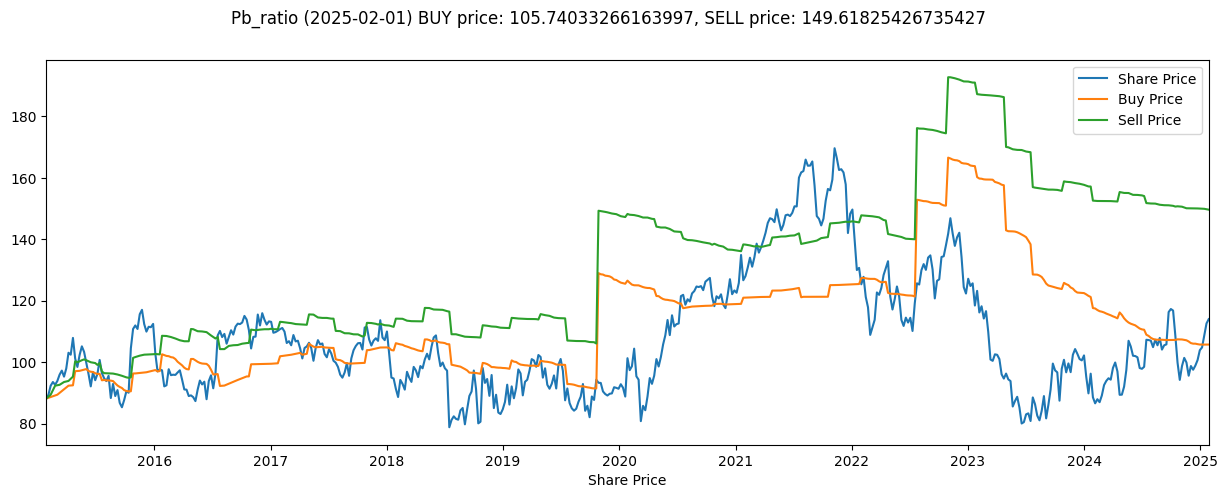

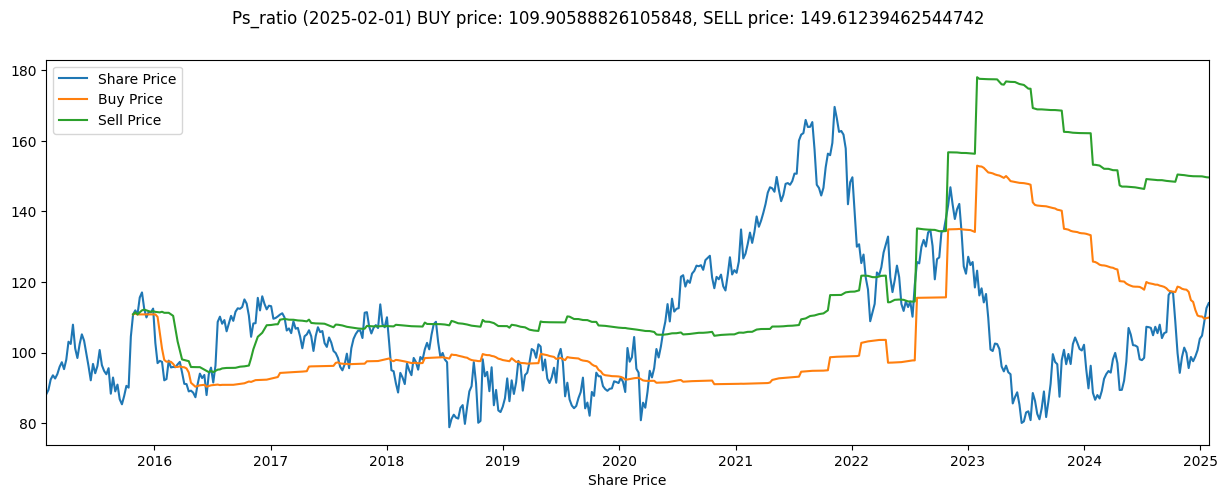

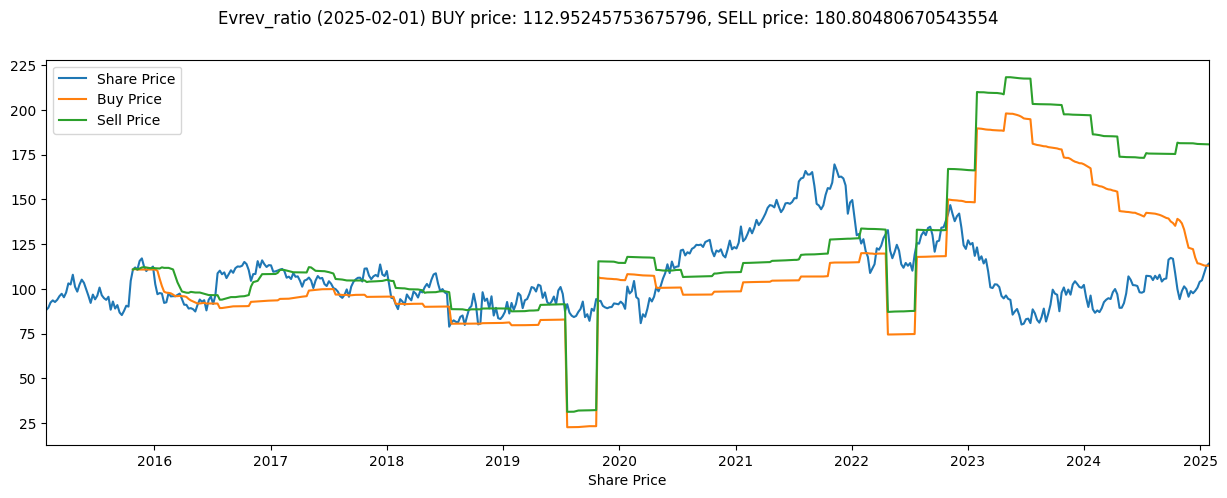

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)